## Common Ground - Emigration Patterns

This notebook analyses our quantitative research question: To what extent do water management and scarcity indicators predict cross-border emigration since 1990?


Variables:
We are using the Gross Emigration rate as it allows us to measure water as a push factor. It is taken from the UN migration dataset [1].
For measures of water availability we are using water resources per capita, total internal renewable water resources per capita, and water consumption per capita, as available from FAO Aquastat [2].
Including measures on water safety / access to safe drinking would be an additional factors, however not enough data was found to be available.

As there is no direct measure available of the quality of water infrastructure, we are using water use efficiency (SDG 6.4.1) and water stress (SDG 6.4.2) as latent variables [2].

For the completeness of the model, we are also modeling the direct economic dependency of water through agricultural dependence [2] and using GDP per capita as a general predictor [1].
Furthermore, to add social context we build a dataset from water conflicts [4].

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

Loading the migration and population data from the UN migration dataset. The population data is needed for calculating per capita measures.

In [2]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
#Migration and population data
migr = pd.read_excel('data/un_migration_origin.xlsx', sheet_name='Table 1', skiprows=10)
popu = pd.read_excel('data/un_migration.xlsx', sheet_name='Table 2', skiprows=10)
columns = ['Area',1990,1995,2000,2005,2010,2015,2020,2024,
           '1990.m','1995.m','2000.m','2005.m','2010.m','2015.m','2020.m','2024.m',
           '1990.f','1995.f','2000.f','2005.f','2010.f','2015.f','2020.f','2024.f']
migr = migr.drop(columns=['Index','Unnamed: 3','Coverage','Location code'])
migr.columns = columns
migr['Area'] = migr['Area'].str.rstrip('*')
popu = popu.drop(columns=['Unnamed: 0', 'Population notes','Location code'])
popu.columns = columns
popu['Area'] = popu['Area'].str.rstrip('*')
popu['Area'] = popu['Area'].str.lstrip(' ')

Loading data on water availability and infrastructure from the FAO Aquastat dataset [2].
As migration is rather a long-term decision and country-scale effects take time until they cause migration, time-lags make sense.
As the Gross Emigration rate is only available for every 5 years, but the independent variables are yearly, we are aggregating
the previous 5 years into the following year (e.g. average of 1990-1994 is the value for 1995) - this also goes for the water conflict data.
The time lagging ignores that the time until effect differs across countries and cases. Including these differences in the model is not feasible due to the scarce data.

In [3]:
water = pd.read_csv("data/aquastat.csv")[['Variable','Country','Year','Value']]
water.rename(columns={'Country':'Area'},inplace=True)

water = water[water['Year']>=1985]
keep_years = [1990,1995,2000,2005,2010,2015,2020,2024]
def compute_rolling_average(df, years):
    df_filtered = pd.DataFrame()
    for year in years:
        start_year = year - 5
        temp_df = df[(df['Year'] > start_year) & (df['Year'] <= year)]
        avg_df = temp_df.groupby(['Variable', 'Area'])['Value'].mean().reset_index()
        avg_df['Year'] = year
        df_filtered = pd.concat([df_filtered, avg_df])
    return df_filtered
water = compute_rolling_average(water, keep_years)
water.reset_index(drop=True, inplace=True)

Loading the water conflict data and merging everything

In [ ]:
migr_long = migr.melt(id_vars=["Area"], var_name="Year", value_name="Value")
migr_long['Variable'] = 'Migration'
df = pd.concat([migr_long, water], ignore_index=True)
df = df[df['Area'] != 'Australia/New Zealand']

df = df.pivot(index=['Area', 'Year'], columns='Variable', values='Value').reset_index()
df = df[df['Year'].isin([1990,1995,2000,2005,2010,2015,2020,2024])]
popu_long = popu.melt(id_vars=["Area"], var_name="Year", value_name="Population")
df = df.merge(popu_long, on=["Area", "Year"], how="left")

water_conflicts_all = pd.read_csv('data/Water Conflict - Triggers.csv')
water_conflicts_all['Area'] = water_conflicts_all['Country']

df = df.merge(water_conflicts_all, on=['Area','Year'],how='left')

df = df.set_index(['Area','Year'])
df['Event_Count'] = df['Event_Count'].fillna(0)

Various variables need to log-transformed as they act exponentially. For example, an additional 100m³ in water consumption have a much larger impact on society in a country with extreme water scarcity than for countries which already have more than enough water available. This also applies to GDP.

In [6]:
#log GDP per capita
df['log_GDPpC'] = np.log(df['Gross Domestic Product (GDP)']/(1000*df['Population']))
#log total internal renewable water resources per capita
df['log_TIRWRpC'] = np.log(df['Total internal renewable water resources per capita']+1)
#log total renewable water resources per capita
df['log_TRWRpC'] = np.log(df['Total renewable water resources per capita']+1)
#log water withdrawal per capita
df['log_TWWpC'] = np.log(df['Total water withdrawal per capita']+1)
#log Water Use Efficiency
df['log_WUE'] = np.log(df['SDG 6.4.1. Water Use Efficiency']+1)

#Human Development Index
df['HDI'] = df['Human Development Index (HDI) [highest = 1]']
df['Agri'] = df['Agricultural water withdrawal as % of total water withdrawal']

df['bEvents'] = df['Event_Count'].apply(lambda x: int(bool(x)))

df['log_pop'] = np.log(df['Population'])
df['agr_GDP'] = df['Agriculture, value added (% GDP)']

df['Water_Stress'] = np.log(df['Total water withdrawal per capita']/(df['Total renewable water resources per capita']+1))


The migration target variable follows a count distribution, since counts of (e)migrants are measured. This is also very visible below. 
Even using a log-distribution results in a skewed distribution.

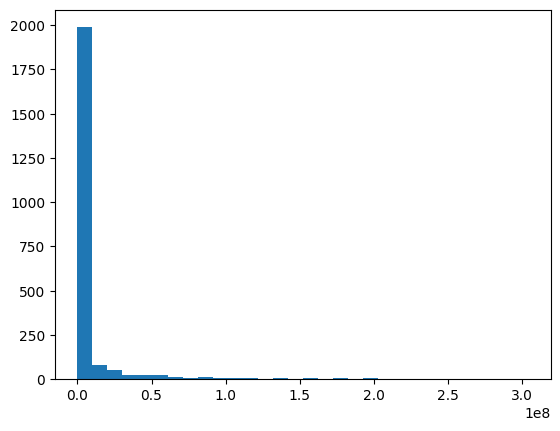

In [6]:
plt.hist(df['Migration'],bins=30)
plt.show()

Note: The data is not zero-inflated:

In [7]:
min(df['Migration'])

22.0

To decide whether to use Poisson or a Negative Binomial distribution, checking the overdispersion:

In [8]:
print(df['Migration'].var(),df['Migration'].mean())

673764175691934.8 7782998.730633803


The target variable is significantly overdispersed, thus a model which allows for Negative Binomial distribution makes sense. 

The data is and should also be treated as panel data,
due to the country-specific effects.
Panel data models have been a popular choice in explaining migration and show an increased performance over uniform models, as described in the report.

Existing climate migration models - which are conceptually and practically closely related to our water-based emigration model - have been critised for relying on linear models and focusing on statistical significance of predictors instead of explaining the data [6].
This can result in opposing insights.

Given the negative binomial distribution and panel effects, we decided to make use of the LaGa Boost Algorithm [5].
It allows to model negative binomial likehoods for panel data with an adapted LightGBM. Boosted models are generally able to achieve state-of-the-start predictive performance.

### Base Model

In [9]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score
import gpboost as gpb
import shap
import optuna
from optuna.samplers import TPESampler
sampler = TPESampler(seed=0) #randomness sampler for improved reproducability
optuna.logging.set_verbosity(optuna.logging.WARNING)

The chosen LaGaBoost model requires hyperparameter tuning. Given the small size of the dataset (n≈1100) this creates a large risk for overfitting, which is why 5-fold Group Cross-Validation is applied as well. For the panel groups we are only using the Area (country) and not area and year, due to the extremely limited data.

In [14]:
model_1_a = df[['Migration',
'log_GDPpC', 'Water_Stress', 'log_TIRWRpC','Agri', 
'bEvents', 'HDI','agr_GDP']].reset_index()

model_1_a['Area'] = model_1_a['Area'].astype('category')
model_1_a['Year'] = model_1_a['Year'].astype('category')
model_1_a = model_1_a.dropna()

groups = model_1_a['Area'].cat.codes
model_1_a['panel_id'] = model_1_a['Area'].astype(str)
model_1_a['panel_id'] = model_1_a['panel_id'].astype('category').cat.codes
groups = model_1_a['panel_id'].values

X = model_1_a.drop(['Migration','panel_id','Area','Year'],axis=1)
y = model_1_a['Migration']

def objective_a(trial, X, y, groups):
    np.random.seed(0)
    n_splits = 5
    kf = GroupKFold(n_splits=n_splits, shuffle=True, random_state=0)
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 2.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 2.0),
        'verbose': 0,
    }
    mae_scores = []
    for train_idx, test_idx in kf.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        group_train, group_test = groups[train_idx], groups[test_idx]
        gp_model = gpb.GPModel(group_data=group_train, likelihood="negative_binomial",seed=0)
        train_data = gpb.Dataset(X_train, label=y_train)
        bst = gpb.train(params=params, train_set=train_data, gp_model=gp_model, num_boost_round=200)
        preds = bst.predict(data=X_test, group_data_pred=group_test)['response_mean']
        mae_scores.append(mean_absolute_error(y_test, preds))
    return np.mean(mae_scores)

study_a = optuna.create_study(direction='minimize',sampler=sampler)
study_a.optimize(lambda trial: objective_a(trial, X, y, groups), n_trials=25)

### Bias detection

How could bias have entered the model? 

1. Data quality might differ across countries:
While the missing data seems to be at random, it is harder to assess the data quality. As countries measure certain variables, especially (e)migration, in different ways, this creates inconsistencies.
2. The model cannot capture the complex system:
Since we are not using any interaction effects, specific reinforcing relationships cannot be modelled well.


For bias detection we binned countries into their respective GDP per capita quartile.
As GDP per capita is already a predictor, we are using post-hoc fairness auditing as our guiding principle.
Below we are checking the directional bias using the mean residual and the prediction accuracy using the SMAPE (Symmetric Mean Absolute Percentage Error).
SMAPE was chosen, because we can not assume statistical parity across groups, since the average emigration counts differ across the GDP quartiles. Furthermore, the scale within countries also varies widely. Additionally over- and underprediction should be treated equally, thus simply using the Mean Relative Error (MRE) would not work as well.

In [15]:
#training the best model
best_params = study_a.best_trial.params
gp_model = gpb.GPModel(group_data=groups, likelihood="negative_binomial",seed=0)
train_data = gpb.Dataset(X, label=y)
bst = gpb.train(params=best_params, train_set=train_data, gp_model=gp_model, num_boost_round=200)
predictions = bst.predict(data=X, group_data_pred=groups)['response_mean']

[GPBoost] [Info] Total Bins 1532
[GPBoost] [Info] Number of data points in the train set: 1160, number of used features: 7
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=13.173458
[GPBoost] [Info] Start training from score 13.173458


In [16]:
#binning into GDP quartiles
model_1_a['GDP_Quartile'] = pd.cut(model_1_a['log_GDPpC'],
                                    bins=[-float('inf')] + model_1_a['log_GDPpC'].quantile([0.25, 0.50, 0.75]).tolist() + [float('inf')],
                                    labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [17]:
#creating a dataframe for fairness metrics
def fairness_metrics(df, predictions):
    results = pd.DataFrame({
        'y_true':       df['Migration'],
        'y_pred':       predictions,
        'GDP_Quartile': df['GDP_Quartile']
    })
    results['residual']  = results['y_pred'] - results['y_true']
    results['abs_error'] = results['residual'].abs()

    def _group(g):
        smape = (2 * (g['y_pred'] - g['y_true']).abs() / 
                (g['y_pred'].abs() + g['y_true'].abs() + 1e-9)).mean()
        return pd.Series({
            'Mean_Prediction': g['y_pred'].mean(),
            'Mean_Residual':   g['residual'].mean(),
            'SMAPE':           smape,
            'R2':              r2_score(g['y_true'], g['y_pred'])
        })

    return results.groupby('GDP_Quartile').apply(_group).reset_index()

fairness_metrics(model_1_a,predictions)

C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\1941988142.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return results.groupby('GDP_Quartile').apply(_group).reset_index()
C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\1941988142.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return results.groupby('GDP_Quartile').apply(_group).reset_index()


,GDP_Quartile,Mean_Prediction,Mean_Residual,SMAPE,R2
0,Q1,1088666.771,79575.678,0.206,0.908
1,Q2,1479330.767,-40892.295,0.135,0.968
2,Q3,1300473.662,-343.600,0.104,0.970
3,Q4,773102.286,-3289.893,0.082,0.987


For the Q2-Q4 GDP per capita quartiles the model predicted the emigration too low, while for the lowest GDP per capita quartile the model predicted too high. The SMAPE shows much better prediction performance for the upper two quartiles than for the lower two, with a general tendency of improved performance each ascending quartile. 
The model overfits/focuses heavily on Q3/Q4 as also seen with the r². The residual for Q1, and to a lesser extent that of Q2, is significantly larger than that of Q3 and Q4.

### Bias reduction - SMOGN

To reduce the bias we are employing oversampling, so that there is a more equal representation of the data.
SMOGN (Synthetic Minority Over-sampling Technique for Regression with Gaussian Noise) extends SMOTE to work for regression and makes use of feature and target distributions while adding Gaussian Noise for smooth samples.

In [18]:
#!pip install smogn
import smogn

Oversampling using SMOGN:

In [19]:
model_1_b = model_1_a.copy()
#categorical codes need to be integers for SMOGN
model_1_b['Area_cat'] = model_1_b['Area'].astype('category').cat.codes
model_1_b['Year_cat'] = model_1_b['Year'].astype('category').cat.codes
#save mapping
area_mapping = dict(enumerate(model_1_b['Area'].astype('category').cat.categories))
year_mapping = dict(enumerate(model_1_b['Year'].astype('category').cat.categories))
#numeric only
model_1_b_smogn = model_1_b.drop(columns=['Area', 'Year','GDP_Quartile'])
model_1_b_smogn = model_1_b_smogn.reset_index(drop=True)

model_1_b_resampled = smogn.smoter(data=model_1_b_smogn,
    y='Migration',k=5,samp_method='extreme',rel_thres=0.8)
model_1_b_resampled = model_1_b_resampled.reset_index(drop=True)
#map back
model_1_b_resampled['Area'] = model_1_b_resampled['Area_cat'].map(area_mapping)
model_1_b_resampled['Year'] = model_1_b_resampled['Year_cat'].map(year_mapping)
model_1_b_resampled = model_1_b_resampled.drop(columns=['Area_cat', 'Year_cat'])

model_1_b = model_1_b_resampled
model_1_b['Migration'] = round(model_1_b['Migration'])

r_index: 100%|##########| 47/47 [00:00<00:00, 508.05it/s]


Hyperparamter optimisation using the oversampled data:

In [20]:
model_1_b['panel_id'] = model_1_b['Area'].astype(str)
model_1_b['panel_id'] = model_1_b['panel_id'].astype('category').cat.codes
groups = model_1_b['panel_id'].values

X = model_1_b.drop(['Migration','panel_id','Area','Year'],axis=1)
y = model_1_b['Migration']

study_b = optuna.create_study(direction='minimize',sampler=sampler)
study_b.optimize(lambda trial: objective_a(trial, X, y, groups), n_trials=25)

Making predictions:

In [21]:
best_params = study_b.best_trial.params
gp_model = gpb.GPModel(group_data=groups, likelihood="negative_binomial",seed=0)
train_data = gpb.Dataset(X, label=y)
bst = gpb.train(params=best_params, train_set=train_data, gp_model=gp_model, num_boost_round=200)
predictions = bst.predict(data=X, group_data_pred=groups)['response_mean']

[GPBoost] [Info] Total Bins 1532
[GPBoost] [Info] Number of data points in the train set: 1797, number of used features: 7
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=14.699476
[GPBoost] [Info] Start training from score 14.699476


Splitting into GDP Quartiles to detect bias:

In [22]:
model_1_b['GDP_Quartile'] = pd.cut(model_1_b['log_GDPpC'],
    bins=[-float('inf')] + model_1_b['log_GDPpC'].quantile([0.25, 0.50, 0.75]).tolist() + [float('inf')],
    labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [23]:
fairness_metrics(model_1_b,predictions)

C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\1941988142.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return results.groupby('GDP_Quartile').apply(_group).reset_index()
C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\1941988142.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return results.groupby('GDP_Quartile').apply(_group).reset_index()


,GDP_Quartile,Mean_Prediction,Mean_Residual,SMAPE,R2
0,Q1,2611653.430,89739.768,0.236,0.798
1,Q2,3860001.760,70988.433,0.264,0.776
2,Q3,3394507.085,1633.339,0.282,0.812
3,Q4,2266264.328,2333.198,0.234,0.855


All the measures are now much more within a similar range regarding their SMAPE and r². The model predicts relatively equally across all GDP per capita quartiles. Only for Q3 the model overpredicts instead of underpredicting. However, the residuals of the other quartiles are within the same order of magnitude.
While the overall performance is worse - supposedly primarily due the Gaussian/random noise - the fairness is much better.

Another downside of this strategy are the oversampling assumptions, as the specific fixed effects of across are so unique that it is not convincing to assume they can be well oversampling with Gaussian noise.

### Bias Reduction - Multi-Objective Optimisation

Ideally, it would be possible to improve the fairness, while also improving the prediction performance.
Thus, as a second strategy, we are optimising the performance, while also optimising the error disparity, which we measure here as the difference between the highest and lowest SMOTE. Here, the SMOTE is not measured for each GDP quartile, but for each fold of the Group k-fold split.

In [261]:
def group_smape_disparity(y_true, y_pred, groups, eps=1e-9):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': groups})
    def _smape(gr):
        numer = (2 * (gr['y_pred'] - gr['y_true']).abs())
        denom = gr['y_pred'].abs() + gr['y_true'].abs() + eps
        return (numer/denom).mean()
    vals = df.groupby('group').apply(_smape)
    return ((vals - vals.min()) ** 2).mean()

In [47]:
#this is needed later, dictionary of Area to panel id
id_area_dict = model_1_a[['Area','panel_id']].set_index('Area').to_dict()['panel_id']

In [262]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

model_1_c = model_1_a.copy()
model_1_c['panel_id'] = model_1_c['Area'].astype(str)
model_1_c['panel_id'] = model_1_c['panel_id'].astype('category').cat.codes
groups = model_1_c['panel_id'].values

X = model_1_c.drop(['Migration','panel_id','Area','Year','GDP_Quartile'],axis=1)
y = model_1_c['Migration']

def objective_c(trial, X, y, groups):
    n_splits = 5
    kf = GroupKFold(n_splits=n_splits, shuffle=True, random_state=trial.number)
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 30),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 2.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 2.0),
        'verbose': 0,
    }
    mae_scores = []
    fairness_scores = []
    for train_idx, test_idx in kf.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        group_train, group_test = groups[train_idx], groups[test_idx]
        gp_model = gpb.GPModel(group_data=group_train, likelihood="negative_binomial",seed=0)
        train_data = gpb.Dataset(X_train, label=y_train)
        bst = gpb.train(params=params, train_set=train_data, gp_model=gp_model, num_boost_round=200)
        preds = bst.predict(data=X_test, group_data_pred=group_test)['response_mean']
        mae_scores.append(mean_absolute_error(y_test, preds))
        fairness_scores.append(group_smape_disparity(y_test, preds, group_test))
    return np.mean(mae_scores), np.mean(fairness_scores)

study_c = optuna.create_study(directions=["minimize", "minimize"], sampler=sampler)
study_c.optimize(lambda trial: objective_c(trial, X, y, groups), n_trials=80)

In [264]:
best_params = study_c.best_trials[2].params
gp_model = gpb.GPModel(group_data=groups, likelihood="negative_binomial",seed=0)
train_data = gpb.Dataset(X, label=y)
bst = gpb.train(params=best_params, train_set=train_data, gp_model=gp_model, num_boost_round=200)
predictions = bst.predict(data=X, group_data_pred=groups)['response_mean']

[GPBoost] [Info] Total Bins 1532
[GPBoost] [Info] Number of data points in the train set: 1160, number of used features: 7
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=13.173458
[GPBoost] [Info] Start training from score 13.173458


In [265]:
model_1_c['GDP_Quartile'] = pd.cut(
    model_1_c['log_GDPpC'],
    bins=[-float('inf')] + model_1_c['log_GDPpC'].quantile([0.25, 0.50, 0.75]).tolist() + [float('inf')],
    labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [266]:
fairness_metrics(model_1_c,predictions)

C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\1941988142.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return results.groupby('GDP_Quartile').apply(_group).reset_index()


,GDP_Quartile,Mean_Prediction,Mean_Residual,SMAPE,R2
0,Q1,1004701.013,-4390.080,0.069,0.984
1,Q2,1580194.304,59971.242,0.109,0.969
2,Q3,1314114.001,13296.739,0.119,0.982
3,Q4,778618.188,2226.009,0.133,0.956


The multi-objective optimisation strategy worked well. The SMAPE is much lower in both groups than in previous trials and the residuals across groups are also much smaller.

Note: Despite using same seeds for each run, there were slightly different results and in few cases the original model was better, however overall this model performed best across several runs, so we went with it.

In [267]:
bst.save_model('Main_Model.json')

### Model Interpretation

To interprete the models and variables, a SHAP Tree explainer is used.

In [289]:
GDP_Q = model_1_c['GDP_Quartile'].values
#X = X.drop('GDP_Quartile',axis=1)
explainer = shap.TreeExplainer(bst)
shap_explanation = explainer(X)
shap_values = shap_explanation.values

SHAP values from TreeExplainer are computed in log(μ) space because the GPBoost model with a negative binomial likelihood predicts the log of the expected count. However, log-space SHAP values are less intuitive to interpret.
Thus below the SHAP values are converted from log-space to count-space, so each SHAP value directly shows how much each feature increased/decreased the emigration count.

(It is also possible to transform the predictions before determining the SHAP values, however this does not work well here, as the shap Tree Explainer works directly with the tree model. When using purely the values of the predictions, KernelSHAP is the only option within the library, which ignores feature dependence. Thus here it's better to transform the TreeSHAP values.)

In [290]:
log_shap = shap_explanation.values
base_log = shap_explanation.base_values

pred_log = base_log + log_shap.sum(axis=1)
pred_count = np.exp(pred_log)
count_shap = pred_count[:, None] * (1 - np.exp(-log_shap))

In [291]:
I = X.copy()
I['log_GDPpC'] = np.exp(I['log_GDPpC'])
I['log_TIRWRpC'] = np.exp(I['log_TIRWRpC'])/1000
I['Water_Stress'] = np.exp(I['Water_Stress'])
I.columns = ['GDP per capita ($)','Water Stress','Total internal renewable water resources per capita (1000m³)','Agriculture water usage (%)',
'Water as trigger event (binary)','Human Development Index [0,1]','Agricultural dependence of GDP (%)']

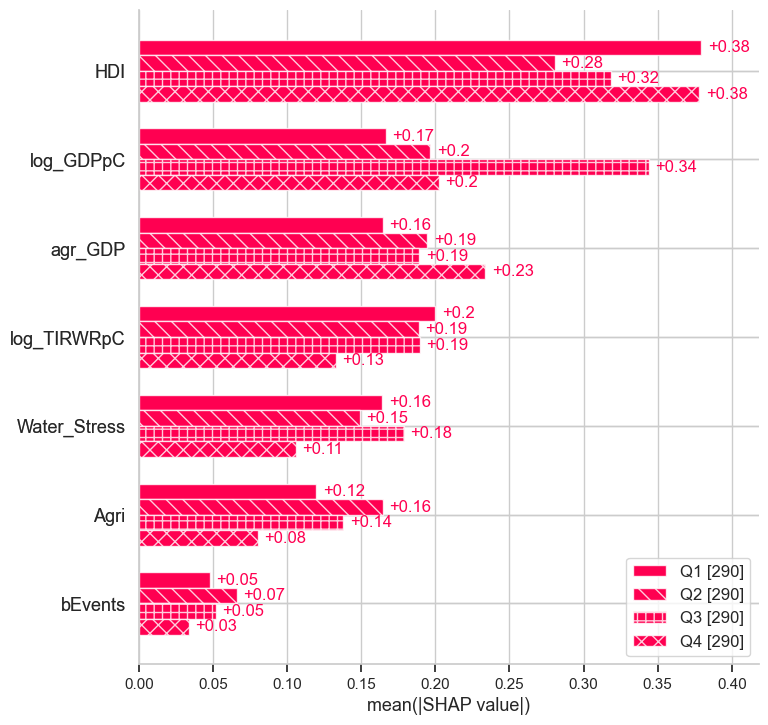

In [292]:
cohort_dict = {}
for q in np.unique(GDP_Q):
    mask = (GDP_Q == q)
    cohort_dict[q] = shap_explanation[mask]

# Now pass that dict to shap.plots.bar():
shap.plots.bar(cohort_dict)

C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\1475060576.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(count_shap, I, plot_size=(15, 10), show=False)


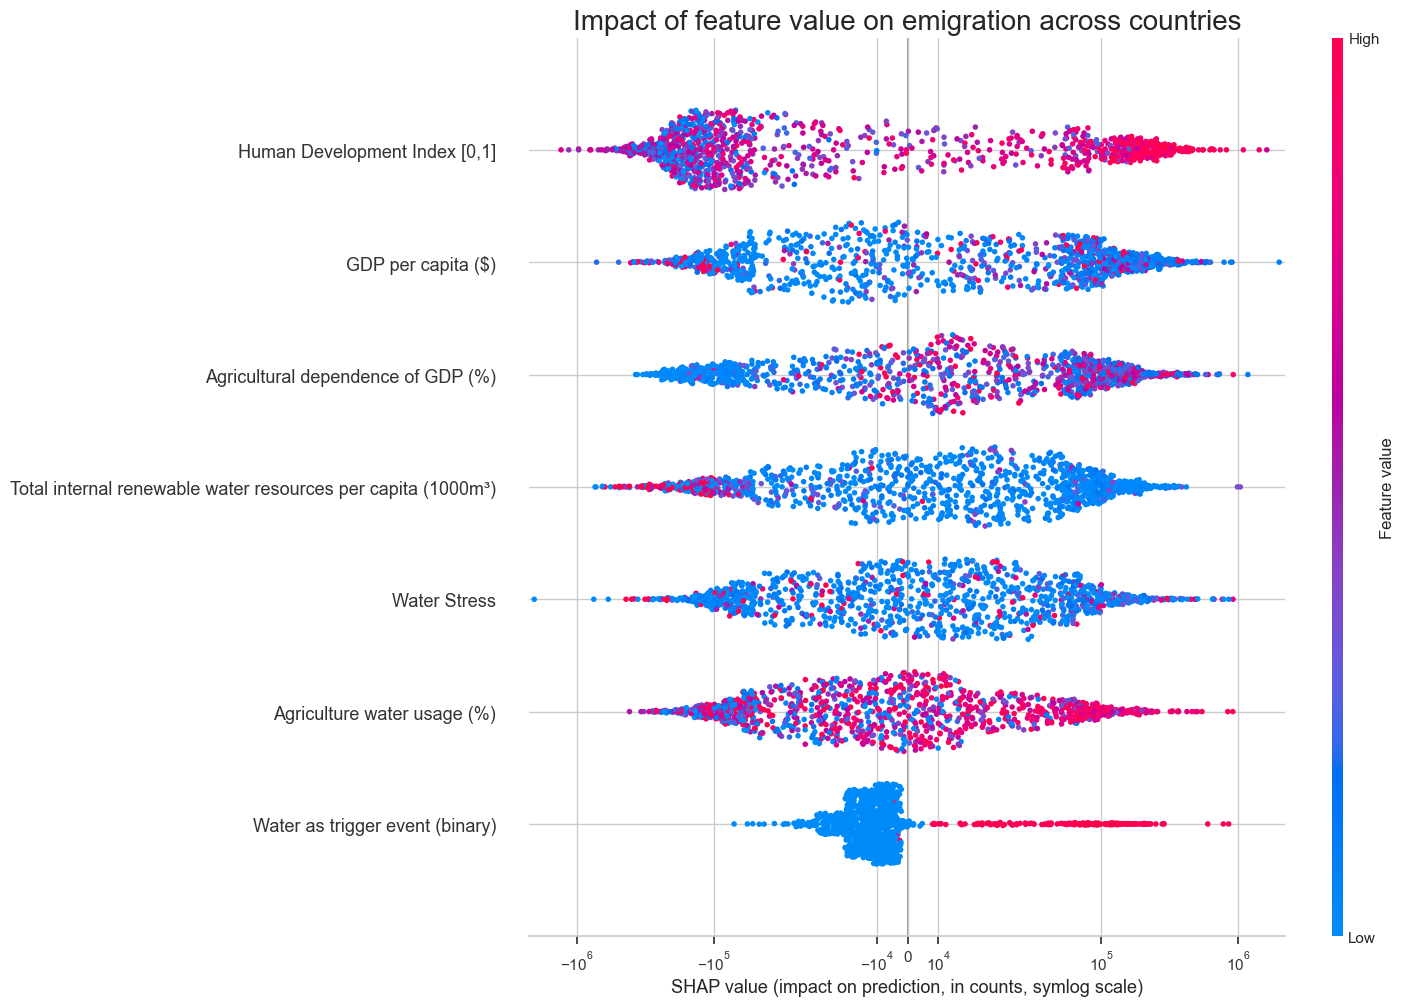

In [300]:
shap.summary_plot(count_shap, I, plot_size=(15, 10), show=False)

plt.gca().set_xscale('symlog', linthresh=50000)
plt.xlabel("SHAP value (impact on prediction, in counts, symlog scale)")
plt.tight_layout()
plt.title('Impact of feature value on emigration across countries',fontsize=20)
plt.show()

C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\1977077345.py:74: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xlims[i])


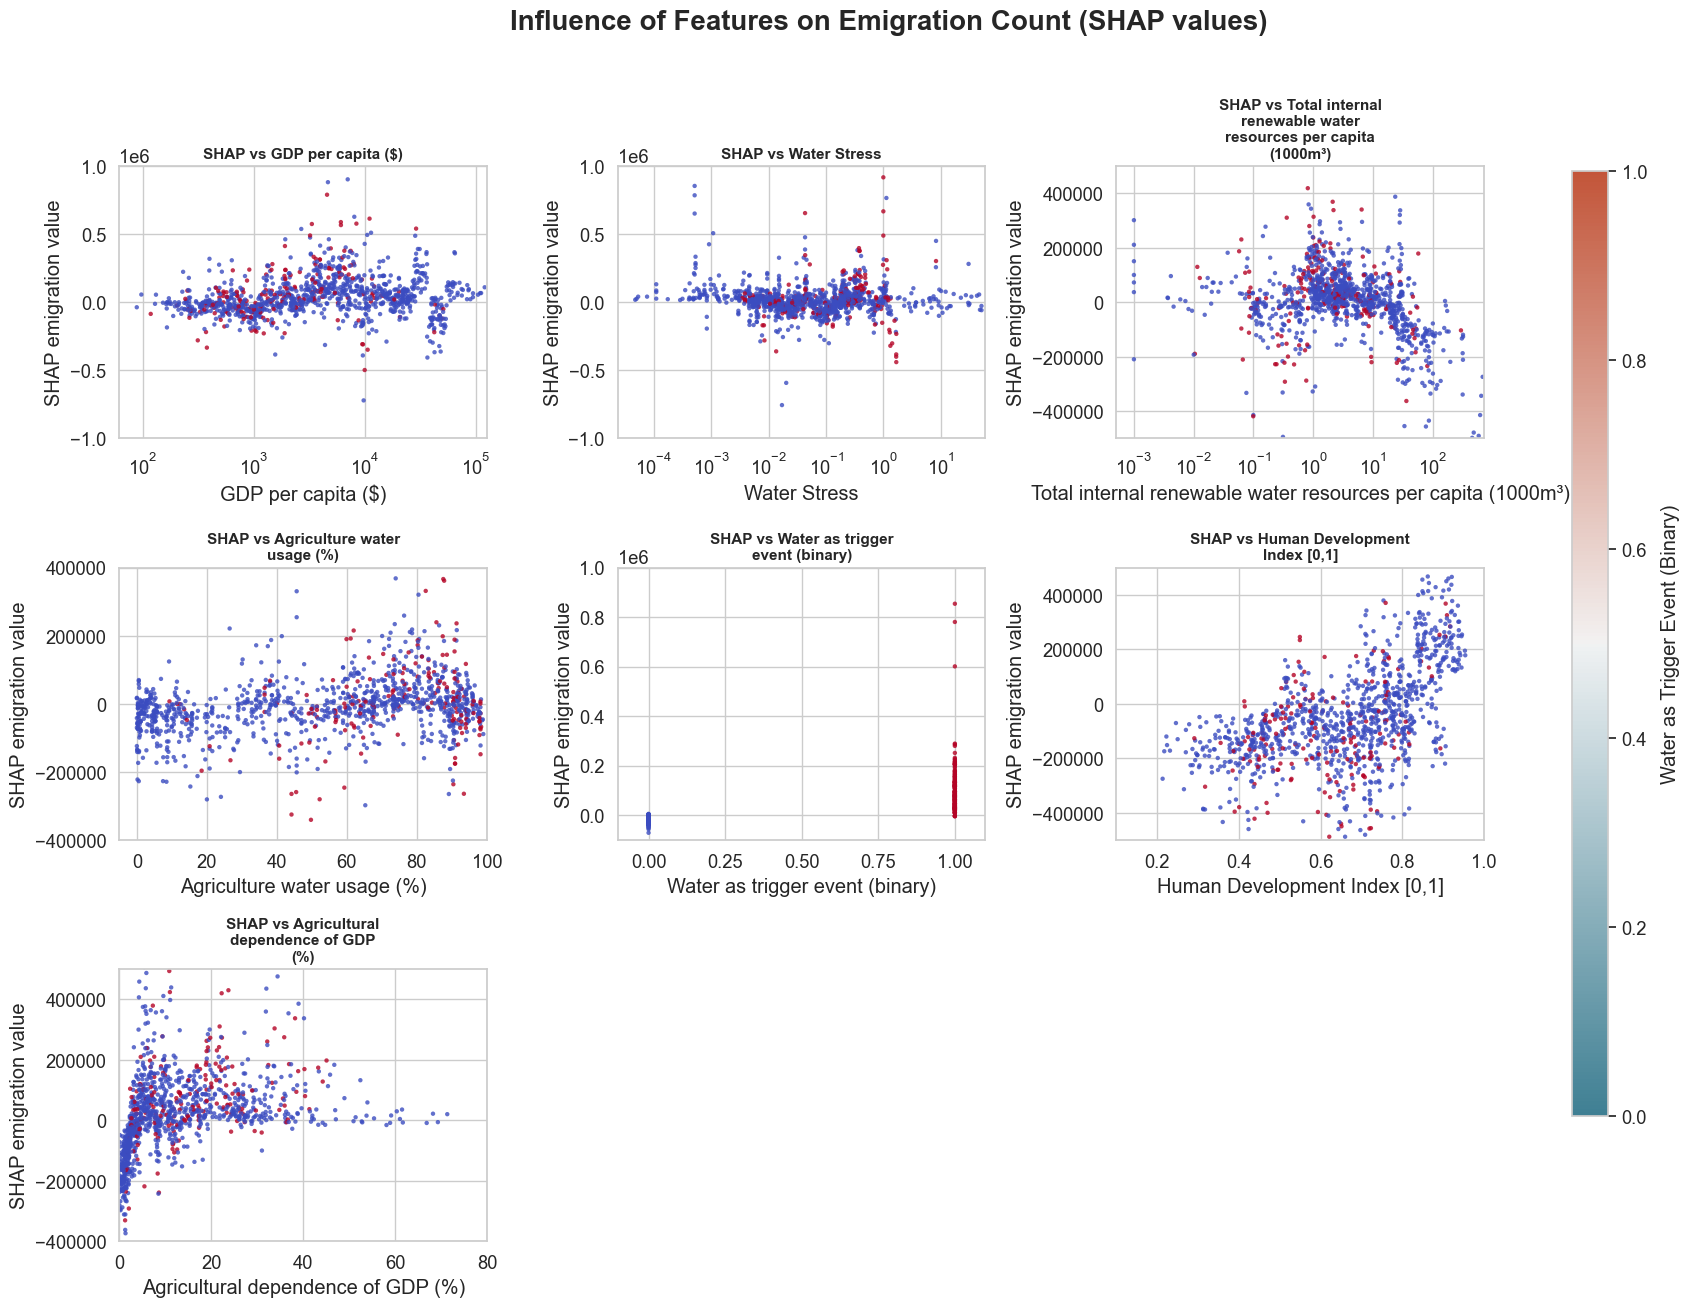

In [ ]:
import math
import textwrap
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

sns.set_theme(style='whitegrid', palette='colorblind', font_scale=1.2)

features = I.columns
n = len(features)
ncols = 3
nrows = math.ceil(n / ncols)

xlims = [(0, 125000),(0, 60),(0, 720),(-5, 100),(-0.1, 1.1),(0.1, 1),(0, 80)]
ylims = [(-1e6, 1e6),(-1e6, 1e6),(-0.5e6, 0.5e6),(-0.4e6, 0.4e6),(-0.1e6, 1e6),(-0.5e6, 0.5e6),(-0.4e6, 0.5e6)]

norm = Normalize(vmin=0, vmax=1)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sm = ScalarMappable(norm=norm, cmap=cmap)

fig, axes = plt.subplots(nrows,ncols,figsize=(ncols * 6, nrows * 4.5),squeeze=False)

for i, feat in enumerate(features):
    row, col = divmod(i, ncols)
    ax = axes[row, col]

    sc = ax.scatter(I[feat], count_shap[:, i], c=I['Water as trigger event (binary)'],
        cmap='coolwarm', s=10, alpha=0.8, linewidth=0)

    if row == 0:
        ax.set_xscale('log')

    wrapped_feat = "\n".join(textwrap.wrap(feat, width=20))
    ax.set_title(f'SHAP vs {wrapped_feat}', fontsize=11, weight='bold')

    ax.set_xlabel(feat)
    ax.set_ylabel('SHAP emigration value')
    ax.set_xlim(xlims[i])
    ax.set_ylim(ylims[i])

for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j // ncols, j % ncols])

plt.tight_layout(rect=[0, 0, 0.85, 0.92])
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Water as Trigger Event (Binary)', labelpad=10)

fig.suptitle('Influence of Features on Emigration Count (SHAP values)',
    fontsize=20,weight='bold',y=0.97)
plt.show()


### Emigration forecasting

Modeling emigration based on different scenarios, such as (no) water-triggered conflict, change in GDP, water stress, etc.

In [ ]:
#renaming is needed to that it merges with the geospatial dataset
most_recent_df = model_1_a.sort_values('Year').groupby('Area').tail(1)
renaming = {'Venezuela (Bolivarian Republic of)':'Venezuela',
'Türkiye':'Turkey','Syrian Arab Republic':'Syria',
'Viet Nam':'Vietnam','Timor-Leste':'East Timor',
'Eswatini':'eSwatini','Iran (Islamic Republic of)':'Iran',
"Côte d'Ivoire":'Ivory Coast','Brunei Darussalam':'Brunei',
'Bolivia (Plurinational State of)':'Bolivia',
'Republic of Moldova':'Moldova','Republic of Korea':'South Korea',
'Russian Federation':'Russia','Serbia':'Republic of Serbia',
"Lao People's Democratic Republic":'Laos'}
most_recent_df['Area'] = most_recent_df['Area'].replace(renaming)
forecast_features_base = most_recent_df[['log_GDPpC','Water_Stress','log_TIRWRpC','Agri','bEvents','HDI','agr_GDP']]
forecast_groups = most_recent_df['panel_id']
forecast_areas = most_recent_df['Area']

C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\895749709.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_recent_df = model_1_a.sort_values('Year').groupby('Area').tail(1)
C:\Users\maxko\AppData\Local\Temp\ipykernel_9884\895749709.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  most_recent_df['Area'] = most_recent_df['Area'].replace(renaming)


In [ ]:
#needed for the website. id to area translation.
most_recent_df[['panel_id','Area']].to_csv('area_id.csv',index=False)

This function models any effects. feature is the feature from the forecast_features_base that is being modeled. impact0 and impact1 are the two different states. If mul is used than the impact0/impact1 is considered a factor (for example when modeling a 10% in water stress worldwide), if mul is false then specific values can be given (for example either 0 or 1 water-triggered conflict event).
It returns the change in % on emigration per country of impact1 in comparison to impact0 (which can be used as baseline then).
The most recent 2024 is used for this.

(Adapt the text based on need!)

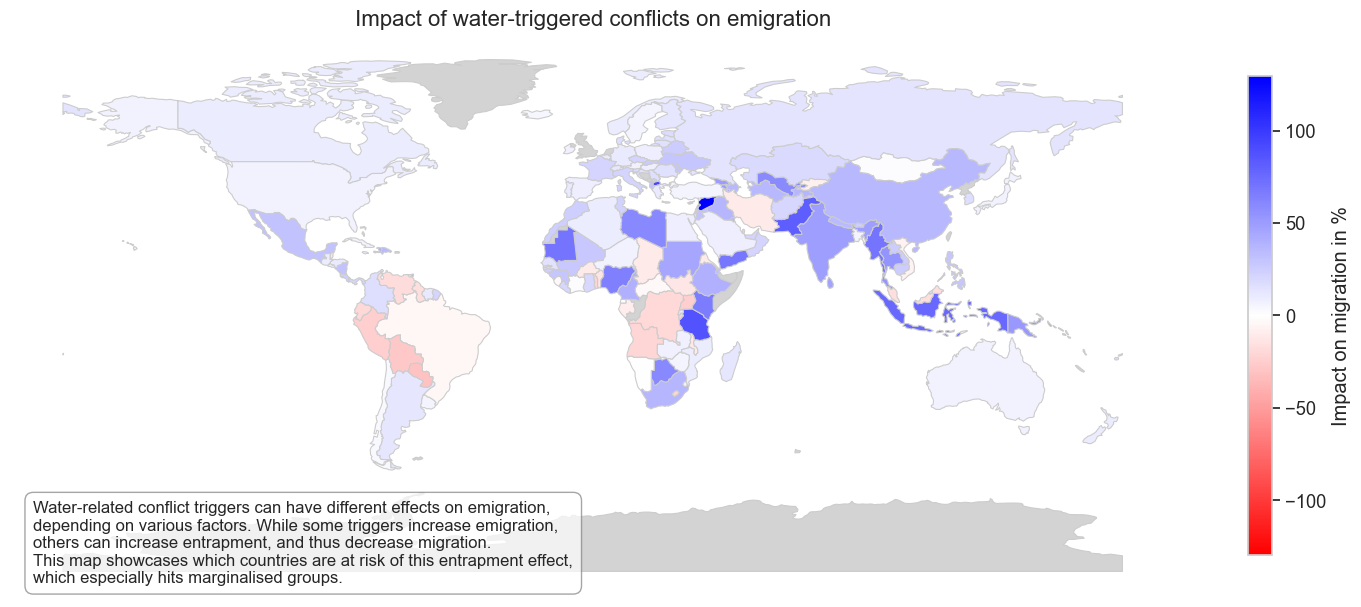

In [367]:

def model_effects(feature, impact0, impact1, mul=True):
    forecast_features_evnt_0 = forecast_features_base.copy()
    forecast_features_evnt_1 = forecast_features_base.copy()

    if mul:
        forecast_features_evnt_0[feature] = forecast_features_evnt_0[feature] * impact0
        forecast_features_evnt_1[feature] = forecast_features_evnt_1[feature] * impact1
    else:
        forecast_features_evnt_0[feature] = impact0
        forecast_features_evnt_1[feature] = impact1

    pred_event_0 = bst.predict(data=forecast_features_evnt_0, group_data_pred=forecast_groups)['response_mean']
    pred_event_1 = bst.predict(data=forecast_features_evnt_1, group_data_pred=forecast_groups)['response_mean']
    forecast_features_evnt_0['pred'] = pred_event_0
    forecast_features_evnt_1['pred'] = pred_event_1
    forecast_features_evnt_0['Area'] = list(forecast_areas)
    forecast_features_evnt_1['Area'] = list(forecast_areas)
    map_filter = pd.DataFrame(columns=['pred0','pred1','Area'])
    map_filter['pred0'] = forecast_features_evnt_0['pred']
    map_filter['pred1'] = forecast_features_evnt_1['pred']
    map_filter['Area'] = forecast_features_evnt_0['Area']
    map_filter['diff'] = ((map_filter['pred1']/ map_filter['pred0'])-1)*100

    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)
    merged = world.merge(map_filter, left_on='ADMIN', right_on='Area', how='left')

    vmin = merged['diff'].min()
    vmax = merged['diff'].max()
    abs_max = max(abs(vmin), abs(vmax))
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged.plot(column='diff',cmap='bwr_r',
        norm=TwoSlopeNorm(vmin=-abs_max, vcenter=0.0, vmax=+abs_max),
        linewidth=0.8,ax=ax,edgecolor='0.8',legend=True,
        legend_kwds={
            "shrink": 0.5,
            "label": "Impact on migration in %"},
        missing_kwds={"color": "lightgrey",
            "label": "No data"})

    textbox_props = dict(boxstyle='round,pad=0.5',facecolor='white',
        alpha=0.7,edgecolor='gray')

    ax.text(0.02,0.02,
        """Water-related conflict triggers can have different effects on emigration,\ndepending on various factors. While some triggers increase emigration,\nothers can increase entrapment, and thus decrease migration.\nThis map showcases which countries are at risk of this entrapment effect,\nwhich especially hits marginalised groups.""",
        transform=ax.transAxes,fontsize=12,
        verticalalignment='bottom',bbox=textbox_props)

    ax.set_title('Impact of water-triggered conflicts on emigration', fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

model_effects('bEvents',0,1,False)

### References

[1] United Nations Department of Economic and Social Affairs, Population Division (2024). International Migrant Stock 2024. https://www.un.org/development/desa/pd/content/international-migrant-stock. Retrieved March 1, 2025. 

[2] Food and Agriculture Organization of the United Nations (FAO). (n.d.). AQUASTAT: FAO’s global information system on water and agriculture. https://www.fao.org/aquastat/en/. Retrieved March 1, 2025.

[4] Pacific Institute (2024) Water Conflict Chronology. Pacific Institute, Oakland, CA. https://www.worldwater.org/water-conflict/. Retrieved April 5, 2025.


[5] Sigrist, F. (2022). Latent Gaussian model boosting. IEEE Transactions on Pattern Analysis and Machine Intelligence, 45(2), 1894-1905.

[6] Beyer, R. M., Schewe, J., & Abel, G. J. (2023). Modeling climate migration: dead ends and new avenues. Frontiers in Climate, 5, 1212649.
